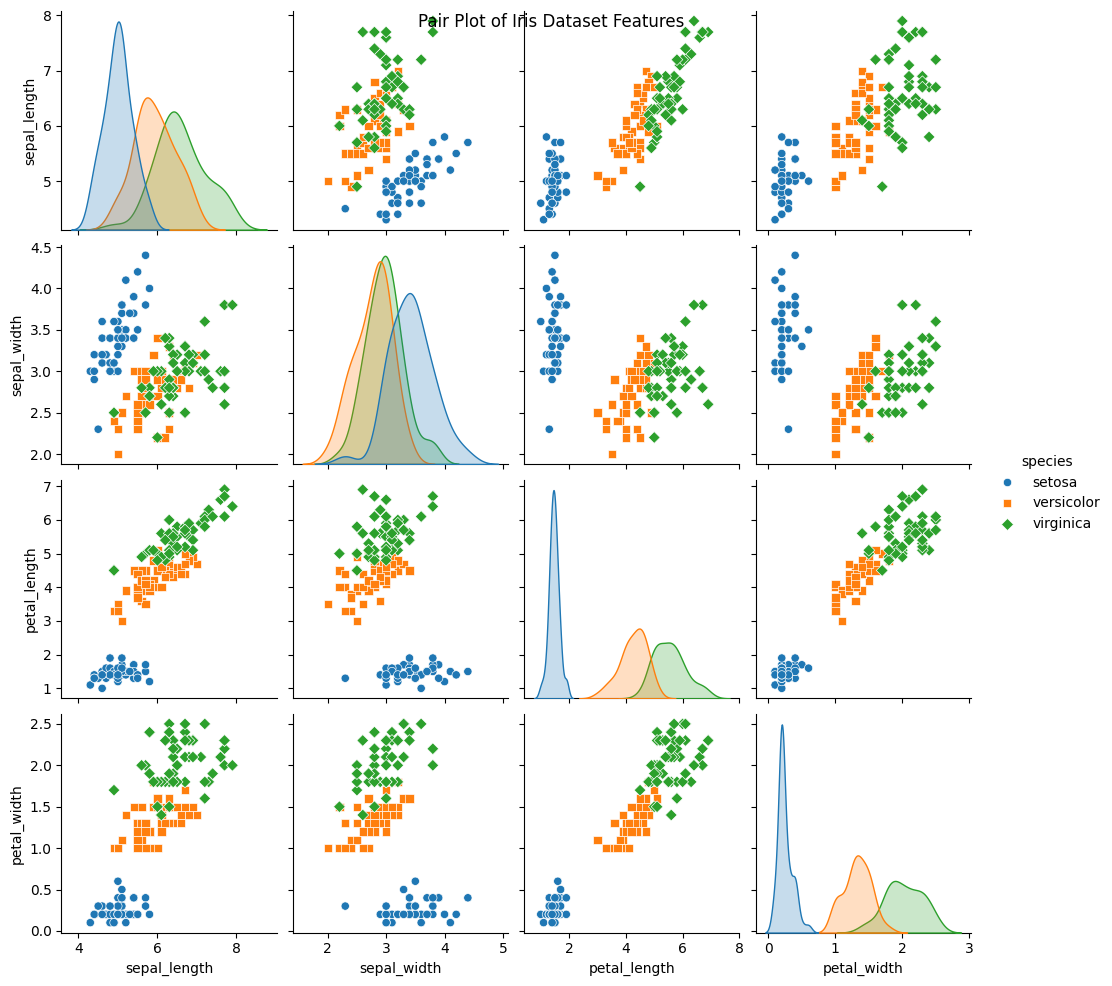

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

iris = load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names
class_names = iris.target_names

# Exploratory Data Analysis (EDA)
def plot_eda(X, y, feature_names, class_names):
    df = sns.load_dataset('iris')
    sns.pairplot(df, hue='species', markers=["o", "s", "D"])
    plt.suptitle("Pair Plot of Iris Dataset Features")
    plt.show()

plot_eda(X, y, feature_names, class_names)


scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
class KernelSVM:
    def __init__(self, kernel='rbf', C=1.0, gamma=0.1, n_iters=1000):
        self.kernel = kernel
        self.C = C
        self.gamma = gamma
        self.n_iters = n_iters
        self.alpha = None
        self.b = None
        self.X = None
        self.y = None

    def _rbf_kernel(self, X1, X2):
        if np.ndim(X1) == 1 and np.ndim(X2) == 1:
            return np.exp(-self.gamma * np.linalg.norm(X1 - X2) ** 2)
        elif np.ndim(X1) == 1 and np.ndim(X2) == 2:
            return np.exp(-self.gamma * np.linalg.norm(X1 - X2, axis=1) ** 2)
        elif np.ndim(X1) == 2 and np.ndim(X2) == 2:
            return np.exp(-self.gamma * np.linalg.norm(X1[:, np.newaxis] - X2[np.newaxis, :], axis=2) ** 2)

    def _kernel(self, X1, X2):
        if self.kernel == 'linear':
            return np.dot(X1, X2.T)
        elif self.kernel == 'rbf':
            return self._rbf_kernel(X1, X2)

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.X = X
        self.y = y
        K = self._kernel(X, X)

        self.alpha = np.zeros(n_samples)
        self.b = 0

        for _ in range(self.n_iters):
            for i in range(n_samples):
                condition = y[i] * (np.sum(self.alpha * y * K[:, i]) + self.b) < 1
                if condition:
                    self.alpha[i] += self.C * (1 - y[i] * (np.sum(self.alpha * y * K[:, i]) + self.b))
                    self.b += self.C * y[i]

    def predict(self, X):
        K = self._kernel(X, self.X)
        return np.sign(np.sum(self.alpha * self.y * K, axis=1) + self.b)


In [9]:
class MultiClassSVM:
    def __init__(self, C=1.0, gamma=0.1, n_iters=1000):
        self.C = C
        self.gamma = gamma
        self.n_iters = n_iters
        self.models = []

    def fit(self, X, y):
        self.classes = np.unique(y)
        for c in self.classes:
            y_binary = np.where(y == c, 1, -1)
            model = KernelSVM(C=self.C, gamma=self.gamma, n_iters=self.n_iters)
            model.fit(X, y_binary)
            self.models.append(model)

    def predict(self, X):
        predictions = [model.predict(X) for model in self.models]
        return self.classes[np.argmax(predictions, axis=0)]


Accuracy: 0.97
Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.89      0.94         9
   virginica       0.92      1.00      0.96        11

    accuracy                           0.97        30
   macro avg       0.97      0.96      0.97        30
weighted avg       0.97      0.97      0.97        30



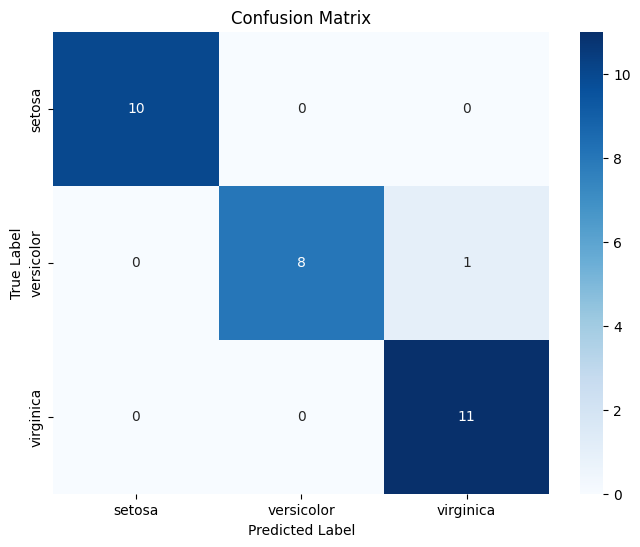

In [10]:

multi_svm = MultiClassSVM(C=1.0, gamma=0.1, n_iters=1000)
multi_svm.fit(X_train, y_train)


y_pred = multi_svm.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


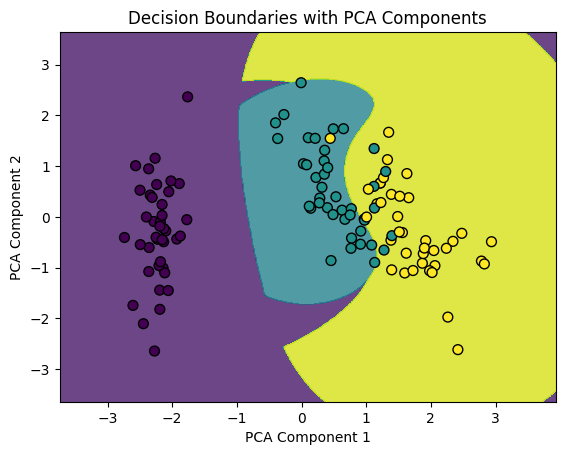

In [11]:
from sklearn.decomposition import PCA


pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


multi_svm_pca = MultiClassSVM(C=1.0, gamma=0.1, n_iters=1000)
multi_svm_pca.fit(X_train_pca, y_train)
y_pred_pca = multi_svm_pca.predict(X_test_pca)

def plot_decision_boundaries(X, y, model):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', s=50)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('Decision Boundaries with PCA Components')
    plt.show()

plot_decision_boundaries(X_train_pca, y_train, multi_svm_pca)
